# Analiza podataka

In [1]:
import os
import cv2
import glob
import seaborn as sns
import fnmatch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Skup podataka sa kojim radimo preuzet je sa sajta 
https://www.kaggle.com/paultimothymooney/breast-histopathology-images
Sve slike su raspoređene po folderima koji su označeni id brojem pacijenta, u svakom od tih foldera nalaze se još dva foldera označena sa 0 i 1 u kojima se nalaze slike u zavisnosti od toga da li su pozitino ili negativno klasifikovane. Svaka slika ima naziv oblika uv_idx5_xX_yY_classC.png, gde uv predstavlja id pacijenta, X i Y su koordinate slajda odakle je izdvojena slika i C označava klasu, 0 - nema tumora, 1 - ima tumor. 


### Učitavanje podataka

In [2]:
imagePatches = glob.glob('C:/Users/pc/Desktop/data/**/*.png', recursive=True) # pokupimo putanje svih slika
for filename in imagePatches[0:10]:
    print(filename)

C:/Users/pc/Desktop/data\10253\0\10253_idx5_x1001_y1001_class0.png
C:/Users/pc/Desktop/data\10253\0\10253_idx5_x1001_y1051_class0.png
C:/Users/pc/Desktop/data\10253\0\10253_idx5_x1001_y1101_class0.png
C:/Users/pc/Desktop/data\10253\0\10253_idx5_x1001_y1151_class0.png
C:/Users/pc/Desktop/data\10253\0\10253_idx5_x1001_y1201_class0.png
C:/Users/pc/Desktop/data\10253\0\10253_idx5_x1001_y1251_class0.png
C:/Users/pc/Desktop/data\10253\0\10253_idx5_x1001_y1301_class0.png
C:/Users/pc/Desktop/data\10253\0\10253_idx5_x1001_y1351_class0.png
C:/Users/pc/Desktop/data\10253\0\10253_idx5_x1001_y1501_class0.png
C:/Users/pc/Desktop/data\10253\0\10253_idx5_x1001_y1551_class0.png


In [3]:
patternZero = '*class0.png'
patternOne = '*class1.png'

In [4]:
# delimo slike, tj. njihove putanje po klasama
classZero = fnmatch.filter(imagePatches, patternZero) 
classOne = fnmatch.filter(imagePatches, patternOne)

In [5]:
def load_images(lowerIndex,upperIndex):
    x = []
    y = []
    width = 50
    height = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        image = cv2.imread(img)
        x.append(cv2.resize(image, (width,height), interpolation=cv2.INTER_CUBIC)) # sve slike moraju biti istih dim 
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [6]:
X,y = load_images(0,500)

In [7]:
X = np.array(X)
y = np.array(y)

In [8]:
X0 = X[y==0]
X1 = X[y==1]

### Osnovne informacije o podacima

Ukupan broj slika:  277524
Broj slika klase 0: 198738
Broj slika klase 1: 78786
Procenat pozitivno klasifikovanih slika: 28.4%
Image.shape: (50, 50, 3)


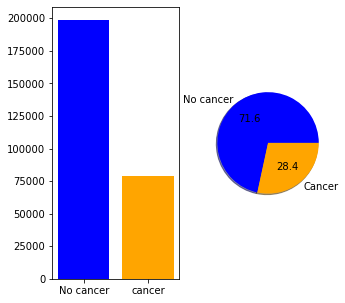

In [9]:
n = len(imagePatches)
num_classZero = len(classZero)
num_classOne = len(classOne)
print('Ukupan broj slika: ', n)
print('Broj slika klase 0:', num_classZero)
print('Broj slika klase 1:', num_classOne)
print('Procenat pozitivno klasifikovanih slika: {:.1f}%' .format(100*(num_classOne/n)))
print('Image.shape:', X[0].shape)
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.bar([0,1],[num_classZero,num_classOne], color = ['blue','orange'], tick_label = ['No cancer','cancer'])
plt.subplot(1, 2, 2)
plt.pie([num_classZero,num_classOne],labels = ['No cancer','Cancer'], colors = ['blue','orange'], autopct = '%1.1f', shadow = True)
plt.show()

### Nebalansiranost klasa

Iz prethodne analize vidimo da se radi o nebalansiranom skupu podataka. 
Za rešavanje ovog probema odlučili smo da koristimo **under-sampling** metod, prvenstveno da ne bismo povećavali skup podataka zbog ograničenih performansi računara. Najbitniji preduslov za korišćenje ove tehnike je dovoljan broj instanci manjinske klase, a kako radimo sa velikim skupom podataka smatramo da je ovaj uslov ispunjen. Ovaj metod iz skupa instanci većinske klase, bira onoliko instanci koliko ih ima u manjinskoj klasi i tako daje izbalansiran skup podataka. S obzirom da se prilikom under-samplinga deo podataka odbacuje, može doći do gubitka informacija, pa je svakako u interesu isprobati i druge metode kao što su over-sampling i ansambli koje teže ka tome da iskoriste sve podatke, i videti kako se svaka od ovih metoda ponaša, u smislu krajnjih rezultata modela.

### Izgled slika i zapažanja

In [10]:
def plot_img(imgs):
    fig = plt.figure(figsize=(12,6))
    columns = 6
    rows = 3
    for i in range(1,columns*rows+1):
        fig.add_subplot(rows,columns,i)
        img = imgs[i]
        plt.imshow(img, cmap='gray')
    plt.show()

Slike koje sadrže tumor:


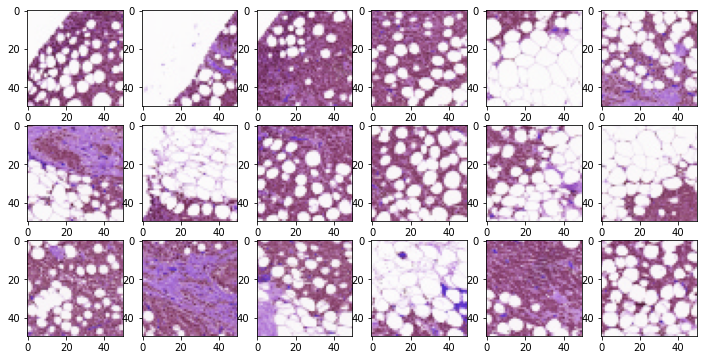

In [11]:
print('Slike koje sadrže tumor:')
plot_img(X1)

Slike koje ne sadrže tumor:


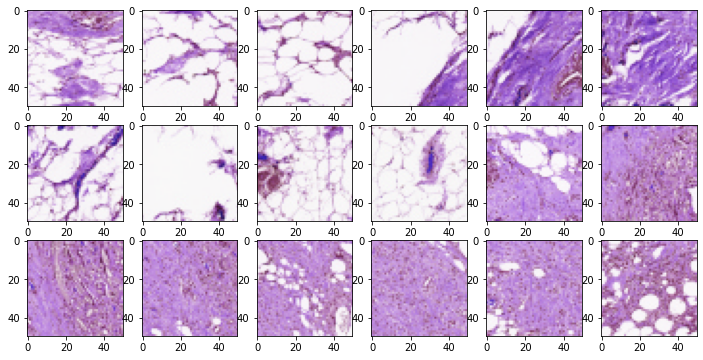

In [12]:
print('Slike koje ne sadrže tumor:')
plot_img(X0)

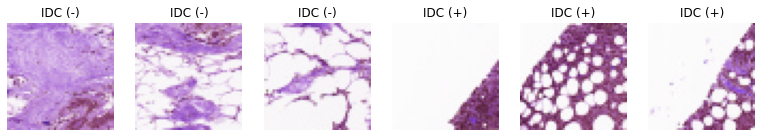

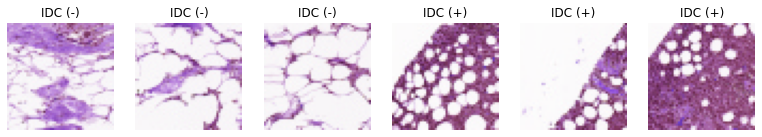

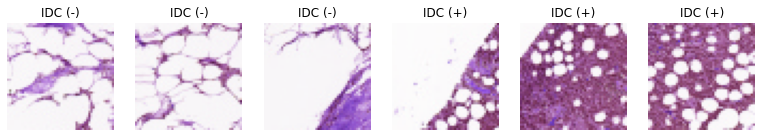

In [12]:
def plot1(imgs0,imgs1): 
    for row in range(3):
        plt.figure(figsize=(18, 18))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('IDC (-)') # OVDE BIH STAVIO NESTO TIPA BEZ TUMORA
            plt.imshow(imgs0[row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('IDC (+)') # OVDE BIH STAVIO NESTO TIPA BEZ TUMOR
            plt.imshow(imgs1[row+col])
            plt.axis('off')
plot1(X0, X1) 

Na osnovu vizuelnog prikaza slika možemo da primetimo da pozitivno klasifikovane slike imaju delove obojene tamno ljubičastom bojom, dok negativno klasifikovane slike uglavnom imaju delove obojene svetlo ljubičastom bojom. Ipak, među negativno klasifikovanim slikama postoje one koje imaju delove obojene tamno ljubičastom bojom, što je, pretpostavljamo, posledica toga da i one sarže maligne ćelije koje su im pripale usled podele velikog slajda, ili je možda posledica vrste ćelija i sa kog mesta je uzeto tkivo. Patolog bi sigurno dao dobar odgovor na ove nedoumice :)

### Detaljnija analiza slika

Da bismo se detaljnije upoznali sa našim podacima, napravićemo dataFrame koja će za svaku sliku sadržati putanju te slike, id pacijenta, x i y koordinate i ciljnu promenljivu. 

In [13]:
def extract_path(paths):
    d = {'path':[],'patient_id':[],'x_coord':[],'y_coord':[],'target':[]}
    for path in paths:
        d['path'].append(path)
        l = path.split('_')
        d['x_coord'].append(l[2][1:])
        d['y_coord'].append(l[3][1:])
        l1 = l[0].split('\\')
        d['patient_id'].append(l1[len(l1)-1])
        d['target'].append(l1[len(l1)-2])
    data = pd.DataFrame(d,columns = ['path','patient_id','x_coord','y_coord','target'])
    return data

In [14]:
data = extract_path(imagePatches)

In [15]:
data.head()

,path,patient_id,x_coord,y_coord,target
0,C:/Users/pc/Desktop/data\10253\0\10253_idx5_x1...,10253,1001,1001,0
1,C:/Users/pc/Desktop/data\10253\0\10253_idx5_x1...,10253,1001,1051,0
2,C:/Users/pc/Desktop/data\10253\0\10253_idx5_x1...,10253,1001,1101,0
3,C:/Users/pc/Desktop/data\10253\0\10253_idx5_x1...,10253,1001,1151,0
4,C:/Users/pc/Desktop/data\10253\0\10253_idx5_x1...,10253,1001,1201,0


In [16]:
patient_id = np.unique(data['patient_id'])
num_pat = len(patient_id)
print('Ukupan broj pacijenata:' , num_pat)

Ukupan broj pacijenata: 279


In [17]:
num_img = np.bincount(data['patient_id'])
num_img = num_img[np.where(num_img!=0)]

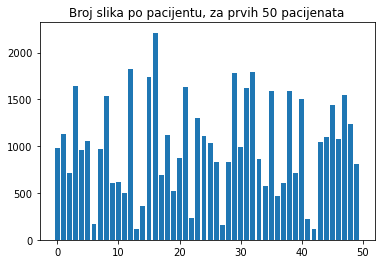

In [18]:
plt.bar(np.arange(50), num_img[:50])
plt.title('Broj slika po pacijentu, za prvih 50 pacijenata')
plt.show()

In [19]:
num_idc = []
num_no_idc = []
freq_idc = []
for i in range(num_pat):
    t = data['target'][data['patient_id']==patient_id[i]]
    num_idc.append(np.bincount(t)[1])
    num_no_idc.append(np.bincount(t)[0])
    p = np.bincount(t)[1]/(np.bincount(t)[0]+np.bincount(t)[1])
    freq_idc.append(np.int(p*100))

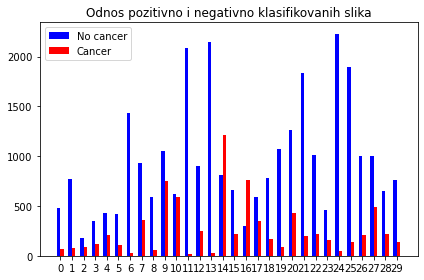

In [20]:
labels = np.arange(30)
x = np.arange(30)
width = 0.3
fig, a = plt.subplots()
a.bar(x-width/2, num_no_idc[:30], width, label = 'No cancer', color = 'blue')
a.bar(x+width/2, num_idc[:30], width, label = 'Cancer', color = 'red')
a.set_title('Odnos pozitivno i negativno klasifikovanih slika')
a.set_xticks(x)
a.legend(loc='best')
fig.tight_layout()
plt.show()

Proverićemo da li postoje pacijenti koji imaju više od 50% pozitivno klasifikovanih slika.

In [21]:
print('Broj pacijenata koji imaju više od 50% pozitivno klasifikovanih slika je:',np.sum(np.array(freq_idc)>50))

Broj pacijenata koji imaju više od 50% pozitivno klasifikovanih slika je: 58


Možemo da primetimo da broj slika po pacijentu veoma varira, kao i broj pozitivno označenih slika, što nas navodi na to da se zapitamo da li sve slike pokazuju istu rezoluciju ćelija tkiva ili se to razlikuje od pacijenta do pacijenta i da li su sve slike dobijene od slajdova na isti način. Takodje, da li tkivo pacijenata koji sadrže veći broj pozitivno klasifikovanih slika(>80%) prikazuje isti deo tkiva kao kod ostalih pacijenata ili je tkivo skoncentrisano samo na kancerogeni deo.

Na osnovu datih koordinata možemo da rekonstruišemo izgled slajda, što nam daje zanimljiv pogled na tkivo pod mikroskopom. S obzirom da broj slika znatno varira od pacijenta do pacijenta, rekonstrukcija nekih slajdova ne mora biti potpuna.

In [25]:
def CeoSlajdVizualizacija(patient_id):
    
    # izdvajamo podatke vezane za pacijenta ciji slajd rekonstruisemo:
    data_patient = data[data['patient_id'] == str(patient_id)]
    data_patient['x_coord'] = data_patient['x_coord'].astype(int)
    data_patient['y_coord'] = data_patient['y_coord'].astype(int)
    # izdvajamo najdalju tacku od koordinatnog pocetka:
    max_point = [data_patient['y_coord'].max()-1, data_patient['x_coord'].max()-1]
    # pravimo mrezu u koju cemo smestiti slajd kada slozimo sve male slike
    # dimenzije mreze moraju da budu takve da u nju mozemo da slozimo od najblize do najdalje male slike
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    # pravimo masku koju cemo staviti "preko slike", ona ce sadrzati lokacije tumora
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    
    # Ucitavamo sliku po sliku za naseg pacijenta
    for i in range(len(data_patient)):
        
            image = cv2.imread(data_patient.path.values[i])
            target = np.int(data_patient.target.values[i])
            
            x_coord = np.int(data_patient.x_coord.values[i])
            y_coord = np.int(data_patient.y_coord.values[i])
            # Koordinate od kojih pocinjemo smestanje slike u mrezu
            x_start = x_coord - 1
            y_start = y_coord - 1
            # Koordinate sa kojima zavrsavamo smestanje slike u mrezu
            x_end = x_start + 50
            y_end = y_start + 50
            # Smestamo sliku na njenu poziciju 
            grid[y_start:y_end, x_start:x_end] = image
            # Ako slika sadrzi tkivo zahvaceno tumorom maska ce na tim pozicijama imati vrednost vecu od 0
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0

    return grid, mask

In [26]:
slajd, tumor = CeoSlajdVizualizacija(patient_id[0])

C:\Users\pc\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\pc\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


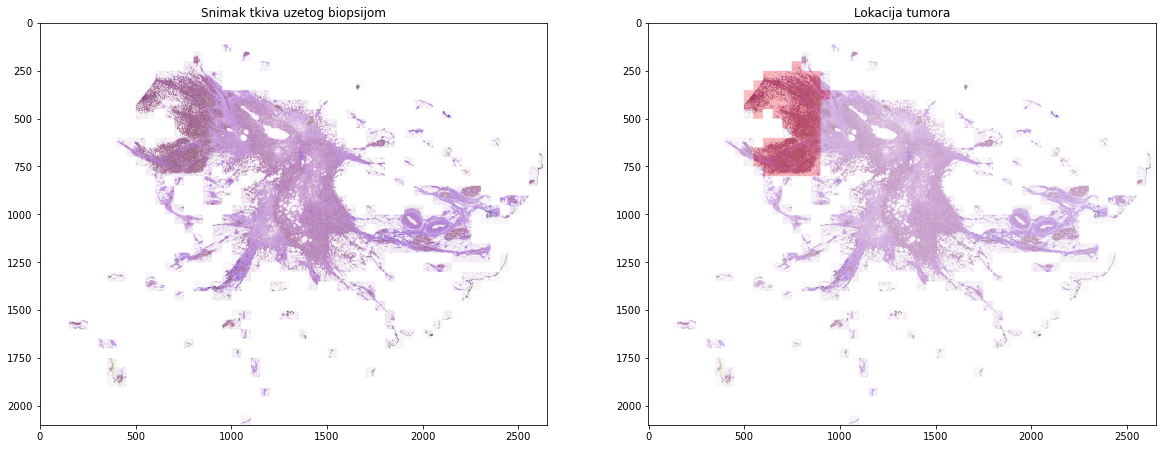

In [27]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(slajd, alpha=0.9) # parametar alfa kontrolise prozirnost slike
ax[1].imshow(tumor, alpha=0.8)
ax[1].imshow(slajd, alpha=0.7)
ax[0].set_title("Snimak tkiva uzetog biopsijom")
ax[1].set_title("Lokacija tumora")
plt.show()

C:\Users\pc\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\pc\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


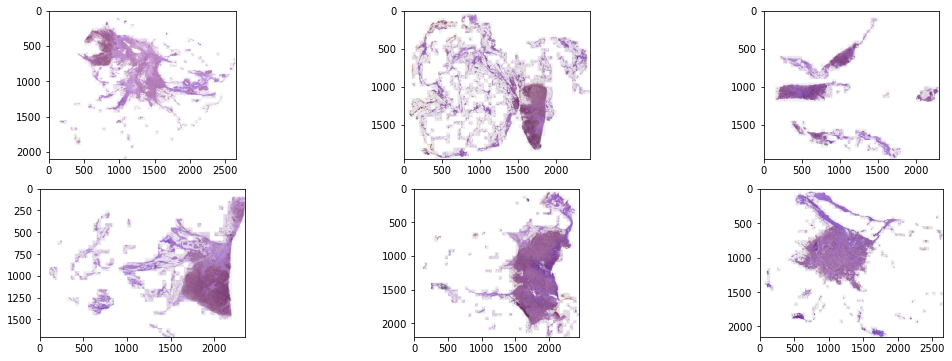

In [28]:
fig = plt.figure(figsize=(18,6))
columns = 3
rows = 2
for i in range(1,columns*rows+1):
    fig.add_subplot(rows,columns,i)
    slajd, tumor = CeoSlajdVizualizacija(patient_id[i-1])
    plt.imshow(slajd, cmap='gray')
plt.show()